In [80]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import random

seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.use_deterministic_algorithms(mode=True)
gen = torch.Generator()
gen.manual_seed(seed)

## Read the data
Read the data, then apply binarization. We convert the ratings to '1' when rating value is higher than 3. 

In [81]:
import zipfile
import pandas as pd
with zipfile.ZipFile("./../data/ml-latest-small.zip") as z:
    with z.open("ml-latest-small/ratings.csv") as f:
        ratings = pd.read_csv(f, delimiter=",")

In [82]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [83]:
ratings['datetime'] = ratings['timestamp'].apply(lambda x: dt.datetime.fromtimestamp(x / 1000.0))
ratings["date"] = pd.to_datetime(ratings['datetime']).dt.date
interactions = ratings[ratings.rating > 3]
ratings.shape, interactions.shape

((100836, 6), (61716, 6))

In [84]:
interactions.userId.nunique(), interactions.movieId.nunique()

(609, 7363)

## Split the data
Split the data based on timestamp. First let's inspect number of interactions per day in our dataset.

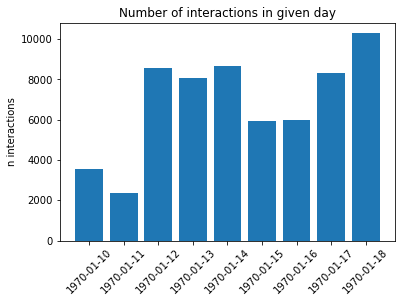

In [85]:
n_interactions = interactions.groupby("date").agg(n_obs=("userId","count")).reset_index()
n_interactions
plt.bar(n_interactions.date, n_interactions.n_obs)
plt.title("Number of interactions in given day")
plt.ylabel("n interactions")
plt.xticks(rotation=45)
plt.show()

Let's split the data on the last day. So in our example this will be day "1970-01-18". <br />
**Question: <br /> What are the advantages and disadvantages of such split compared to other types of splits? For other types of splitting consider random split* and leave-one-out split\**.** <br />
\* Random split is just randomly selecting interactions for test set. <br />
\** Leave-one-out split is selecting just one item for each user. Assume that we know temporal ordering and in such case leave-one-out selects last item from each user interaction history. Recall, that's not the same ase leave-one-out cross validation strategy!!!

**Answer:** 
Greatest advantage of this type of split is it's robustness to data leakages phenomena. For random split is trivial to see why leakage can happen. In leave-one-out split, last interaction of certain user can have a timestamp smaller than some observations from test set. This is dangerous, as some information from train data can leak to test set. One of the disadvantages is poor users coverage. Having test set taken from just one day, most of the users will have exactly zero interactions during that day (so we won't know how model will handle them in real scenario). Moreover, some users will have many interactions, other only one or two. Most of the ranking metrics at some point average the score over users - they don't consider that some users had more interacions in test set.

In [86]:
split_date = "1970-01-18"
train = interactions[interactions.datetime < split_date]
test = interactions[interactions.datetime >= split_date]
train.datetime.max(), len(train), test.datetime.min(), len(test)

(Timestamp('1970-01-17 23:59:44.741000'),
 51431,
 Timestamp('1970-01-18 00:04:28.014000'),
 10285)

Our train and test datasets look valid. We have around 50k and 10k observations in train and test, respectively. Due to the nature of choosen split latter number can change. <br />
**Question: <br />
Why is that?**

**Answer:** <br />
We haven't checked if all users (or items) from test set have at least one interaction in train set. If there is no interaction for given user / item in train set the model won't be able to learn how to generate recommendations for given user or item. Therefore, we may need to remove users (or items) which are not present in train set

In [87]:
users, items = train.userId.unique(), train.movieId.unique()
n_users, n_items = len(users), len(items)
users_df = pd.DataFrame(users, columns=["userId"])
items_df = pd.DataFrame(items, columns=["movieId"])
u_to_ids = {user:idx for idx,user in enumerate(users)}
i_to_ids = {item:idx for idx,item in enumerate(items)}
train["users_mapped"] = train["userId"].apply(lambda x: u_to_ids[x])
train["items_mapped"] = train["movieId"].apply(lambda x: i_to_ids[x])
n_users, n_items

C:\Users\marzecm\AppData\Local\Temp\ipykernel_15996\1918217346.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["users_mapped"] = train["userId"].apply(lambda x: u_to_ids[x])
C:\Users\marzecm\AppData\Local\Temp\ipykernel_15996\1918217346.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["items_mapped"] = train["movieId"].apply(lambda x: i_to_ids[x])


(532, 6236)

In [88]:
print(f"Test n obs before merge = {test.shape[0]}")
test_valid = test.merge(users_df, on="userId").merge(items_df, on="movieId")
print(f"Test n obs after merge = {test_valid.shape[0]}")

Test n obs before merge = 10285
Test n obs after merge = 803


It looks like we have removed more than 90% of test set! This is very rare situation, but we are working on educational dataset, so this is not that important. It is just a subset of the whole MovieLens dataset, and we don't know how exactly the data was collected.

## Model
In currect section we will implement Matrix Factorization model (and Neural Matrix Factorization model) 
### Matrix Factorization
**Exercise:**<br /> Implement matrix factorization model. Use the cell below as a guide (change given functions).

In [89]:
class MF(nn.Module):
    def __init__(self, n_factors=None):
        pass
    
    def forward(self, user, item):
        pass
        

In [90]:
class MatrixFactorization(nn.Module):
    def __init__(self, n_factors=None, n_users=None, n_items=None):
        super().__init__()
        self.n_factors = n_factors
        self.users = nn.Embedding(n_users, n_factors)
        self.items = nn.Embedding(n_items, n_factors)
    
    def forward(self, user, item):
        user_emb, item_emb = self.users(user), self.items(item)
        return (user_emb * item_emb).sum(dim=1)

## Evaluation
Evaluation of the recommender system can be performed in various settings. The two main ways to do so are online evaluation and offline evaluation. The online evaluation uses a continuous stream of users feedback to access system performance. In practice, it is often difficult to design settings allowing for such evaluation. Offline evaluation is based on historical data and it is the most common way of evaluating recommender system models. When designing evaluation methodology for a recommender system, we have to consider our goals. In the early stages of research in this field, calculating RMSE, MSE or MAE (Mean Absolute Error) was a very popular way of accessing the performance of the recommender system. This was, of course, connected with the data availability - the main datasets available online consisted of explicit ranking. Therefore, recommendation problem was often treated as a regression problem so typical regression metrics were used. When the data was in a binary form - metrics based on classification were used. The current standard are ranking based metrics. They give the biggest weights to the items placed at the top of the ranking list, which mimics the goal of top-k recommendation. <br /> In this tutorial we will focus on **Recall@k** which is a metric build upon Recall used for standard classification problems. For a given user we can define: 
$$Recall@k = \frac{number\ of\ relevant\ items}{total\ number\ of\ items},$$ the number $k$ is the length of the recommendation list. To calculate Recall@k for the whole dataset we average the values of recall for each user. <br />

As we don't have negative interactions we can sample (again ;)) negatives for users from test set. For each user we sample 100 items, and consider them negative. Then if we want to calculate Recall@10 for user $u$ with two items in test set, we need to score all 102 items, and order them accordingly to obtained scores (higher score means higher probability of interaction). For Recall@10 we need to check how many of these two relevant items are in top-10 recommendation list and divide it by the total number of relevant items for this user (=2 in this case). 


**Exercise:**<br />
Implement function for calculating the recall for a given user. Then sample 100 negative items for each user (items have to be different from what is in given user's test set). Calculate recall at cutoffs k=5,10,30 for untrained model. Note: Your recall function doesn't have to have specific arguments defined below, but the solution will refer to them.

In [91]:
def recall_k(k=10, annotated_preds=[]):
    pass
    # k - cutoff value
    # preds - list with tuples (probability, 0/1) indicating predicted scores and label

**Solution:**

In [92]:
test_positives = test_valid.groupby("userId")["movieId"].agg(lambda x: x.tolist())

items_set = set(items)
positives_test = {}
negatives_test = {}
for u,i_pos in zip(test_positives.index, test_positives):
    sampled = np.random.choice(list(items_set - set(i_pos)), size=100, replace=False)
    positives_test[u] = i_pos
    negatives_test[u] = sampled
    
# encode users and items for model
positives_test_encoded = {}
negatives_test_encoded = {}
for u,itms in positives_test.items():
    positives_test_encoded[u_to_ids[u]] = [i_to_ids[i] for i in itms]
for u,itms in negatives_test.items():
    negatives_test_encoded[u_to_ids[u]] = [i_to_ids[i] for i in itms]

In [93]:
# score positives and negatives
def score(model, positives_test_encoded, negatives_test_encoded):
    scored = defaultdict(list)
    for u, itms in positives_test_encoded.items():
        u_tensor = torch.tensor([u]).repeat(len(itms))
        itms = torch.tensor(itms)
        # evaluate model:
        model.eval()
        with torch.no_grad():
            preds = model(u_tensor, itms)
        for p in preds:
            scored[u].append((p.item(),1))

    for u, itms in negatives_test_encoded.items():
        u_tensor = torch.tensor([u]).repeat(len(itms))
        itms = torch.tensor(itms)
        # evaluate model:
        model.eval()
        with torch.no_grad():
            preds = model(u_tensor, itms)
        for p in preds:
            scored[u].append((p.item(),0))
    return scored

In [94]:
def recall_k(k=10, annotated_preds=[]):
    # k - cutoff value
    # preds - list with tuples (probability, 0/1) indicating predicted scores and label
    n = min(k, sum([i[1] for i in annotated_preds]))
    s = sorted(annotated_preds, key=lambda x: x[0], reverse=True)
    r = sum([i[1] for i in s[:k]])
    return r / n

In [95]:
# init random model
model = MatrixFactorization(n_factors=20, n_users=n_users, n_items=n_items)
scored = score(model, positives_test_encoded, negatives_test_encoded)
for k in [5,10, 30]:
    recalls = [recall_k(k, pred) for pred in scored.values()]
    mean_recall = np.mean(recalls)
    print(f"Recall@{k} = {mean_recall}")

Recall@5 = 0.19230769230769232
Recall@10 = 0.2465811965811966
Recall@30 = 0.34155591336991925


In [100]:
# init random model
model = MatrixFactorization(n_factors=20, n_users=n_users, n_items=n_items)
scored = score(model, positives_test_encoded, negatives_test_encoded)
for k in [5,10, 30]:
    recalls = [recall_k(k, pred) for pred in scored.values()]
    mean_recall = np.mean(recalls)
    print(f"Recall@{k} = {mean_recall}")

Recall@5 = 0.1461538461538462
Recall@10 = 0.15000000000000002
Recall@30 = 0.24649791708194588


In [28]:
# helper function, we will use it later during trainig
def score_recall(model, positives_test_encoded, negatives_test_encoded, k):
    scored = score(model, positives_test_encoded, negatives_test_encoded)
    recalls = [recall_k(k, pred) for pred in scored.values()]
    return np.mean(recalls)

## Training
Now, we will train implemented models. We need to define some training hyperparameters (learning rate, batch size and the number of epochs), initilize optimizer and model and implement custom dataset class (we could live without it, but it simplifies code during training) and training loop.

In [37]:
lr = 1e-3
batch_size = 64
n_epochs = 40

For the loss function we will use Binary cross entropy, as we are treating our problem as a classification problem.

In [38]:
model = MatrixFactorization(n_factors=20, n_users=n_users, n_items=n_items)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = nn.BCEWithLogitsLoss()

In [17]:
class MovieLensDataset(Dataset):
    def __init__(self, data, output_col="output"):
        self.users = data.users_mapped.values
        self.items = data.items_mapped.values
        if output_col:
            self.output = data[output_col].values
        else:
            self.output = np.ones(self.users.shape)
        
    def __len__(self):
        return len(self.users)
        
    def __getitem__(self, idx):
        return (self.users[idx], self.items[idx], self.output[idx])

In [31]:
dataset = MovieLensDataset(train, output_col=None)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=gen)

### Train without sampling
In classification problems we have both negative and positive instances, but here we only have positives. In this section we will try to train a model only on positive interactions.

In [39]:
def train_fn(model, optimizer, n_epochs, dataloader, verbose_n_steps=None, eval_recall=True, k=10):
    epoch_losses, recalls = [], []
    global_step = 0
    epoch_loss = []
    for epoch in range(1, n_epochs+1):
        print(f"Running epoch {epoch}")
        tmp_loss = []
        for user, item, output in tqdm(dataloader):
            optimizer.zero_grad()

            # Predict and calculate loss
            prediction = model(user, item)
            loss = loss_function(prediction, output)

            # Backpropagate
            loss.backward()

            # Update the parameters
            optimizer.step()

            global_step += 1
            epoch_loss.append(loss.item())
            
            if verbose_n_steps:
                # store current loss
                tmp_loss.append(loss.item())
            if verbose_n_steps and global_step % verbose_n_steps == 0:
                avg = np.mean(tmp_loss)
                print(f"Step = {global_step}, moving average loss = {avg}")
                tmp_loss = []
                
        e_loss = np.mean(epoch_loss)
        epoch_losses.append(e_loss)
        print(f"Avg loss after epoch {epoch}, is equal to {e_loss}")
        
        if eval_recall:
            r = score_recall(model, positives_test_encoded, negatives_test_encoded, k)
            print(f"Recall@{k} (test set) after epoch {epoch}, is equal to {r}")
            recalls.append(r)
            
    return epoch_losses, recalls

In [40]:
losses, recalls = train_fn(model, optimizer, n_epochs, dataloader, verbose_n_steps=None)

Running epoch 1


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 397.44it/s]


Avg loss after epoch 1, is equal to 1.8510106407988793
Recall@10 (test set) after epoch 1, is equal to 0.24658119658119657
Running epoch 2


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 308.31it/s]


Avg loss after epoch 2, is equal to 1.7544759394481668
Recall@10 (test set) after epoch 2, is equal to 0.2388888888888889
Running epoch 3


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 319.00it/s]


Avg loss after epoch 3, is equal to 1.6642023505973096
Recall@10 (test set) after epoch 3, is equal to 0.23504273504273507
Running epoch 4


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 323.64it/s]


Avg loss after epoch 4, is equal to 1.5809704843825343
Recall@10 (test set) after epoch 4, is equal to 0.2465811965811966
Running epoch 5


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:03<00:00, 255.58it/s]


Avg loss after epoch 5, is equal to 1.5044253219441783
Recall@10 (test set) after epoch 5, is equal to 0.24273504273504276
Running epoch 6


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 331.36it/s]


Avg loss after epoch 6, is equal to 1.4339773110904102
Recall@10 (test set) after epoch 6, is equal to 0.24273504273504276
Running epoch 7


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 285.06it/s]


Avg loss after epoch 7, is equal to 1.3690214341800897
Recall@10 (test set) after epoch 7, is equal to 0.23504273504273504
Running epoch 8


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 289.04it/s]


Avg loss after epoch 8, is equal to 1.308814862990385
Recall@10 (test set) after epoch 8, is equal to 0.22735042735042732
Running epoch 9


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 317.82it/s]


Avg loss after epoch 9, is equal to 1.2527152571692162
Recall@10 (test set) after epoch 9, is equal to 0.20811965811965813
Running epoch 10


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 338.37it/s]


Avg loss after epoch 10, is equal to 1.1999647399148943
Recall@10 (test set) after epoch 10, is equal to 0.20811965811965813
Running epoch 11


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 366.14it/s]


Avg loss after epoch 11, is equal to 1.1498663795451187
Recall@10 (test set) after epoch 11, is equal to 0.20811965811965813
Running epoch 12


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 358.99it/s]


Avg loss after epoch 12, is equal to 1.1017759135258534
Recall@10 (test set) after epoch 12, is equal to 0.21581196581196582
Running epoch 13


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 346.90it/s]


Avg loss after epoch 13, is equal to 1.0551590432868325
Recall@10 (test set) after epoch 13, is equal to 0.23076923076923078
Running epoch 14


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 306.04it/s]


Avg loss after epoch 14, is equal to 1.00971596005123
Recall@10 (test set) after epoch 14, is equal to 0.2269230769230769
Running epoch 15


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 281.79it/s]


Avg loss after epoch 15, is equal to 0.9653882204542736
Recall@10 (test set) after epoch 15, is equal to 0.22692307692307695
Running epoch 16


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 294.48it/s]


Avg loss after epoch 16, is equal to 0.9223468448880429
Recall@10 (test set) after epoch 16, is equal to 0.25
Running epoch 17


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:03<00:00, 261.61it/s]


Avg loss after epoch 17, is equal to 0.8808635983249089
Recall@10 (test set) after epoch 17, is equal to 0.21923076923076923
Running epoch 18


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:03<00:00, 258.52it/s]


Avg loss after epoch 18, is equal to 0.8412260900872175
Recall@10 (test set) after epoch 18, is equal to 0.2269230769230769
Running epoch 19


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 277.16it/s]


Avg loss after epoch 19, is equal to 0.8036493271535068
Recall@10 (test set) after epoch 19, is equal to 0.2269230769230769
Running epoch 20


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 298.99it/s]


Avg loss after epoch 20, is equal to 0.7682532108059766
Recall@10 (test set) after epoch 20, is equal to 0.2423076923076923
Running epoch 21


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 328.91it/s]


Avg loss after epoch 21, is equal to 0.7350745005987195
Recall@10 (test set) after epoch 21, is equal to 0.24615384615384617
Running epoch 22


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 363.45it/s]


Avg loss after epoch 22, is equal to 0.7040756781106091
Recall@10 (test set) after epoch 22, is equal to 0.24230769230769234
Running epoch 23


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 366.62it/s]


Avg loss after epoch 23, is equal to 0.6751687396715724
Recall@10 (test set) after epoch 23, is equal to 0.24615384615384617
Running epoch 24


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 348.16it/s]


Avg loss after epoch 24, is equal to 0.6482373328872993
Recall@10 (test set) after epoch 24, is equal to 0.24615384615384617
Running epoch 25


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 293.65it/s]


Avg loss after epoch 25, is equal to 0.6231511986187706
Recall@10 (test set) after epoch 25, is equal to 0.2538461538461539
Running epoch 26


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 327.26it/s]


Avg loss after epoch 26, is equal to 0.5997747589732229
Recall@10 (test set) after epoch 26, is equal to 0.2538461538461539
Running epoch 27


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 370.92it/s]


Avg loss after epoch 27, is equal to 0.5779732502287835
Recall@10 (test set) after epoch 27, is equal to 0.25811965811965815
Running epoch 28


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 372.74it/s]


Avg loss after epoch 28, is equal to 0.557618199049862
Recall@10 (test set) after epoch 28, is equal to 0.26581196581196587
Running epoch 29


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 338.27it/s]


Avg loss after epoch 29, is equal to 0.538588505462561
Recall@10 (test set) after epoch 29, is equal to 0.2696581196581197
Running epoch 30


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 316.17it/s]


Avg loss after epoch 30, is equal to 0.5207724788291389
Recall@10 (test set) after epoch 30, is equal to 0.2696581196581197
Running epoch 31


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 309.48it/s]


Avg loss after epoch 31, is equal to 0.5040676228106846
Recall@10 (test set) after epoch 31, is equal to 0.27735042735042736
Running epoch 32


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 316.61it/s]


Avg loss after epoch 32, is equal to 0.4883801287679832
Recall@10 (test set) after epoch 32, is equal to 0.30427350427350425
Running epoch 33


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 309.26it/s]


Avg loss after epoch 33, is equal to 0.47362492681248186
Recall@10 (test set) after epoch 33, is equal to 0.31581196581196586
Running epoch 34


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 314.32it/s]


Avg loss after epoch 34, is equal to 0.45972494071658426
Recall@10 (test set) after epoch 34, is equal to 0.31581196581196586
Running epoch 35


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 332.66it/s]


Avg loss after epoch 35, is equal to 0.4466103311438955
Recall@10 (test set) after epoch 35, is equal to 0.3311965811965812
Running epoch 36


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 335.37it/s]


Avg loss after epoch 36, is equal to 0.43421831006756
Recall@10 (test set) after epoch 36, is equal to 0.3350427350427351
Running epoch 37


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 330.51it/s]


Avg loss after epoch 37, is equal to 0.42249206323939165
Recall@10 (test set) after epoch 37, is equal to 0.3350427350427351
Running epoch 38


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 331.96it/s]


Avg loss after epoch 38, is equal to 0.41138019344967897
Recall@10 (test set) after epoch 38, is equal to 0.34273504273504274
Running epoch 39


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 308.48it/s]


Avg loss after epoch 39, is equal to 0.40083628259868076
Recall@10 (test set) after epoch 39, is equal to 0.35042735042735046
Running epoch 40


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:02<00:00, 292.07it/s]

Avg loss after epoch 40, is equal to 0.39081827431721494
Recall@10 (test set) after epoch 40, is equal to 0.35042735042735046


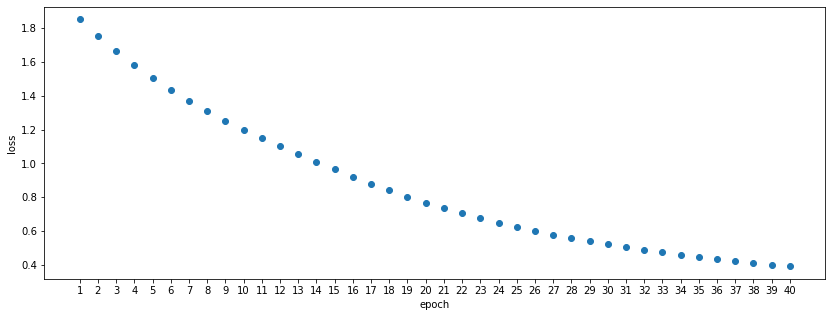

In [41]:
# plot training loss
def plot_vector(vector, title=None, xlabel="epoch", ylabel="loss", figsize=(12,5)):
    plt.figure(figsize=figsize)
    plt.plot([i+1 for i in range(len(vector))],  vector, "o")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks([i+1 for i in range(len(vector))])
    plt.show()

plot_vector(losses, ylabel="loss", figsize=(14,5))

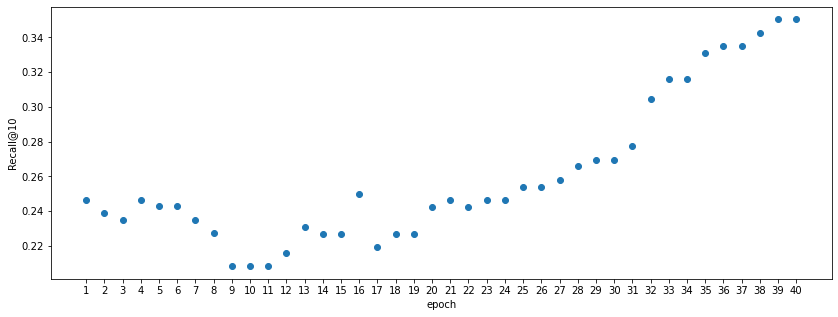

In [42]:
# plot recall@10 on test set
plot_vector(recalls, ylabel="Recall@10", figsize=(14,5))

In [43]:
scored = score(model, positives_test_encoded, negatives_test_encoded)
for k in [5,10, 30]:
    recalls = [recall_k(k, pred) for pred in scored.values()]
    mean_recall = np.mean(recalls)
    print(f"Recall@{k} = {mean_recall}")

Recall@5 = 0.31538461538461543
Recall@10 = 0.35042735042735046
Recall@30 = 0.48000679156622084


### Train with sampling
Here, we want to enrich training data with negative instances. There are many ways of sampling, but for simplicity we will focus on simplest approach - random sampling. It simply samples observations uniformly from (user, item) pairs. <br />

**Exercise:** <br />
For each interaction from train set sample one negative interaction with random sampling. Merge that with training data and train model with the same hyperparameters, for the same number of epochs and compare obtained results. <br />

**Solution:**

In [45]:
n_negatives = train.shape[0]
users_sampled = np.random.choice(users, n_negatives)
items_sampled = np.random.choice(items, n_negatives)
negative_df = pd.DataFrame({"userId":users_sampled, "movieId":items_sampled, "output":np.zeros(n_negatives)})

In [46]:
train_sampled = pd.concat([train[["userId", "movieId"]], negative_df])
train_sampled = train_sampled.fillna(1)
train_sampled["users_mapped"] = train_sampled["userId"].apply(lambda x: u_to_ids[x])
train_sampled["items_mapped"] = train_sampled["movieId"].apply(lambda x: i_to_ids[x])

In [52]:
dataset_sampled = MovieLensDataset(train_sampled)
dataloader_sampled = DataLoader(dataset_sampled, batch_size=batch_size, shuffle=True, generator=gem)


model_negatives = MatrixFactorization(n_factors=20, n_users=n_users, n_items=n_items)

optimizer = torch.optim.Adam(model_negatives.parameters(), lr=lr)
loss_function = nn.BCEWithLogitsLoss()

In [53]:
losses, recalls = train_fn(model_negatives, optimizer, n_epochs, dataloader=dataloader_sampled)

Running epoch 1


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 408.64it/s]


Avg loss after epoch 1, is equal to 1.8333566987359216
Recall@10 (test set) after epoch 1, is equal to 0.17735042735042736
Running epoch 2


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 418.38it/s]


Avg loss after epoch 2, is equal to 1.7072859640175888
Recall@10 (test set) after epoch 2, is equal to 0.1735042735042735
Running epoch 3


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 455.56it/s]


Avg loss after epoch 3, is equal to 1.593676045378119
Recall@10 (test set) after epoch 3, is equal to 0.17350427350427353
Running epoch 4


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:04<00:00, 396.23it/s]


Avg loss after epoch 4, is equal to 1.4923153037240935
Recall@10 (test set) after epoch 4, is equal to 0.17350427350427353
Running epoch 5


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:04<00:00, 396.68it/s]


Avg loss after epoch 5, is equal to 1.4023181214984093
Recall@10 (test set) after epoch 5, is equal to 0.17350427350427353
Running epoch 6


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 444.03it/s]


Avg loss after epoch 6, is equal to 1.3225132443674315
Recall@10 (test set) after epoch 6, is equal to 0.16196581196581197
Running epoch 7


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:04<00:00, 354.08it/s]


Avg loss after epoch 7, is equal to 1.251547110610896
Recall@10 (test set) after epoch 7, is equal to 0.1658119658119658
Running epoch 8


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:05<00:00, 275.45it/s]


Avg loss after epoch 8, is equal to 1.1882889209449214
Recall@10 (test set) after epoch 8, is equal to 0.15427350427350428
Running epoch 9


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:04<00:00, 370.62it/s]


Avg loss after epoch 9, is equal to 1.1315328127715933
Recall@10 (test set) after epoch 9, is equal to 0.15427350427350428
Running epoch 10


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 433.61it/s]


Avg loss after epoch 10, is equal to 1.0802268872870098
Recall@10 (test set) after epoch 10, is equal to 0.15427350427350428
Running epoch 11


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 485.70it/s]


Avg loss after epoch 11, is equal to 1.0334107478568966
Recall@10 (test set) after epoch 11, is equal to 0.15854700854700854
Running epoch 12


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 488.07it/s]


Avg loss after epoch 12, is equal to 0.9903103403772141
Recall@10 (test set) after epoch 12, is equal to 0.17735042735042736
Running epoch 13


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 497.18it/s]


Avg loss after epoch 13, is equal to 0.9504021142706783
Recall@10 (test set) after epoch 13, is equal to 0.1854700854700855
Running epoch 14


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 473.62it/s]


Avg loss after epoch 14, is equal to 0.9132787494291367
Recall@10 (test set) after epoch 14, is equal to 0.2047008547008547
Running epoch 15


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 463.60it/s]


Avg loss after epoch 15, is equal to 0.8786664663515728
Recall@10 (test set) after epoch 15, is equal to 0.20085470085470086
Running epoch 16


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 469.67it/s]


Avg loss after epoch 16, is equal to 0.8463258795807265
Recall@10 (test set) after epoch 16, is equal to 0.20854700854700856
Running epoch 17


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 501.93it/s]


Avg loss after epoch 17, is equal to 0.8160589653788162
Recall@10 (test set) after epoch 17, is equal to 0.21239316239316242
Running epoch 18


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 503.57it/s]


Avg loss after epoch 18, is equal to 0.787673227499893
Recall@10 (test set) after epoch 18, is equal to 0.23162393162393163
Running epoch 19


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 411.94it/s]


Avg loss after epoch 19, is equal to 0.7609878530082764
Recall@10 (test set) after epoch 19, is equal to 0.23162393162393163
Running epoch 20


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 482.38it/s]


Avg loss after epoch 20, is equal to 0.7358561944132538
Recall@10 (test set) after epoch 20, is equal to 0.27008547008547007
Running epoch 21


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 470.81it/s]


Avg loss after epoch 21, is equal to 0.7121487612878388
Recall@10 (test set) after epoch 21, is equal to 0.2623931623931624
Running epoch 22


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 498.59it/s]


Avg loss after epoch 22, is equal to 0.6897368408946674
Recall@10 (test set) after epoch 22, is equal to 0.25854700854700857
Running epoch 23


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 482.40it/s]


Avg loss after epoch 23, is equal to 0.6685247799091895
Recall@10 (test set) after epoch 23, is equal to 0.2504273504273504
Running epoch 24


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 476.69it/s]


Avg loss after epoch 24, is equal to 0.6484151283230456
Recall@10 (test set) after epoch 24, is equal to 0.261965811965812
Running epoch 25


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 481.29it/s]


Avg loss after epoch 25, is equal to 0.6293334925336074
Recall@10 (test set) after epoch 25, is equal to 0.261965811965812
Running epoch 26


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 432.07it/s]


Avg loss after epoch 26, is equal to 0.6112068098347613
Recall@10 (test set) after epoch 26, is equal to 0.25811965811965815
Running epoch 27


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 429.46it/s]


Avg loss after epoch 27, is equal to 0.5939691411406742
Recall@10 (test set) after epoch 27, is equal to 0.2696581196581197
Running epoch 28


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 475.59it/s]


Avg loss after epoch 28, is equal to 0.5775583270936085
Recall@10 (test set) after epoch 28, is equal to 0.2696581196581197
Running epoch 29


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 431.61it/s]


Avg loss after epoch 29, is equal to 0.5619279752258108
Recall@10 (test set) after epoch 29, is equal to 0.2696581196581197
Running epoch 30


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 463.63it/s]


Avg loss after epoch 30, is equal to 0.5470277323950732
Recall@10 (test set) after epoch 30, is equal to 0.27350427350427353
Running epoch 31


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 446.91it/s]


Avg loss after epoch 31, is equal to 0.5328121721663623
Recall@10 (test set) after epoch 31, is equal to 0.27350427350427353
Running epoch 32


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 478.10it/s]


Avg loss after epoch 32, is equal to 0.5192431307230535
Recall@10 (test set) after epoch 32, is equal to 0.28119658119658114
Running epoch 33


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 483.31it/s]


Avg loss after epoch 33, is equal to 0.5062806647230832
Recall@10 (test set) after epoch 33, is equal to 0.2773504273504273
Running epoch 34


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 475.51it/s]


Avg loss after epoch 34, is equal to 0.49389058988085416
Recall@10 (test set) after epoch 34, is equal to 0.2811965811965812
Running epoch 35


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 463.27it/s]


Avg loss after epoch 35, is equal to 0.48204195382506204
Recall@10 (test set) after epoch 35, is equal to 0.2811965811965812
Running epoch 36


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 475.92it/s]


Avg loss after epoch 36, is equal to 0.4707014945362483
Recall@10 (test set) after epoch 36, is equal to 0.27735042735042736
Running epoch 37


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 469.82it/s]


Avg loss after epoch 37, is equal to 0.459842695616191
Recall@10 (test set) after epoch 37, is equal to 0.2773504273504273
Running epoch 38


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 418.95it/s]


Avg loss after epoch 38, is equal to 0.44944277686103484
Recall@10 (test set) after epoch 38, is equal to 0.2811965811965812
Running epoch 39


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 470.90it/s]


Avg loss after epoch 39, is equal to 0.4394690848527059
Recall@10 (test set) after epoch 39, is equal to 0.2811965811965812
Running epoch 40


100%|█████████████████████████████████████████████████████████████████████████████| 1608/1608 [00:03<00:00, 504.34it/s]

Avg loss after epoch 40, is equal to 0.42990228001413516
Recall@10 (test set) after epoch 40, is equal to 0.2811965811965812


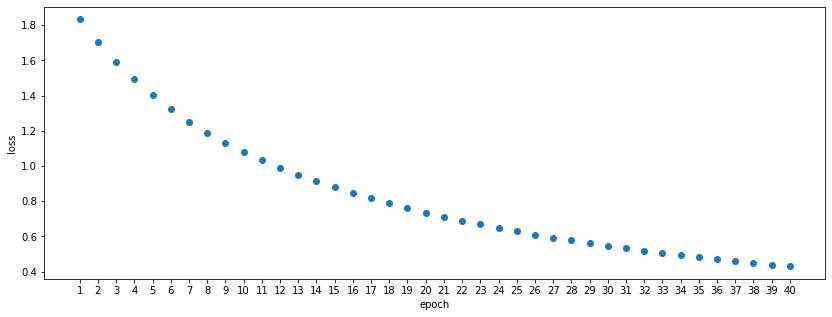

In [54]:
# plot loss on train set
plot_vector(losses, ylabel="loss", figsize=(14,5))

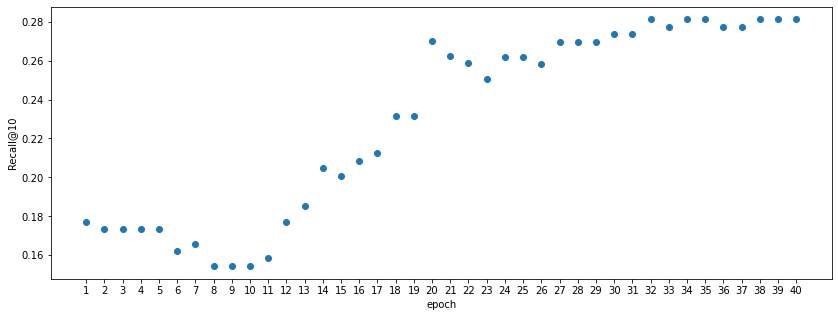

In [55]:
# plot recall@10 on test set
plot_vector(recalls, ylabel="Recall@10", figsize=(14,5))

In [57]:
scored = score(model_negatives, positives_test_encoded, negatives_test_encoded)
for k in [5,10, 30]:
    recalls = [recall_k(k, pred) for pred in scored.values()]
    mean_recall = np.mean(recalls)
    print(f"Recall@{k} = {mean_recall}")

Recall@5 = 0.2923076923076923
Recall@10 = 0.2811965811965812
Recall@30 = 0.42681061824536726


Results are quite suprising. It looks like adding negatives does not improve model performance. There is of course more to it. Random sampling is simplest and weakest sampling methods. Using more advanced sampling techniques (like popularity sampling, where we sample items according to their popularity) could lead to different results. However, from our experiment we can conclude that adding negatives wasn't benefitial.

## Conclusions